### libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tf1.disable_eager_execution()

In [3]:
sns.set_palette("RdBu_r", 7)

### Business and Data Understanding

In [4]:
data = pd.read_csv("SampleOpenEndedSurveyData.csv",skiprows=1)[1:]

In [5]:
data.shape

(3450, 3)

In [6]:
data.columns = ["ID","opinion","role"]

In [7]:
data.sample(5)

,ID,opinion,role
1594,R_3F21S20YbUe0EEC,Seeking customer input prior to implementing m...,Vice President
2109,R_1I4uAHOPSfvDhoG,NaN,Manager
2129,R_1pm42aLKnQ6i6X7,It will be more efficient if Global IT can res...,Manager
1714,R_3EfC8Biscbcx4ps,,Individual Contributor
153,R_3IadgPWiMykn318,Web based apps are too slow. 2 years ago ther...,Manager


In [8]:
data.sample(5)

,ID,opinion,role
3340,R_1QryxdcpZ1dcHIl,NaN,NaN
1907,R_2woZRR6vfPEiVyd,NaN,Director
115,R_8hQEYPcg9mqmxe9,NaN,Individual Contributor
1375,R_pufaKakeLYI8Ubn,NaN,Director
158,R_2rIxSmLjYhNrP0B,Business processes. Everything we try to do tu...,Vice President


In [9]:
data.sample(5)

,ID,opinion,role
867,R_28XKEJqAwoukRi1,NaN,Manager
2834,R_31GgPi0kChQZ7KC,NaN,Manager
3135,R_3PiYauQoxF2t3Gz,NaN,Manager
2006,R_AzXxSu6UKokf6RH,NaN,Vice President
2023,R_2DTGjqWrOVjEa3y,"Cutting the ""red-tape"", integrating more with ...",Individual Contributor


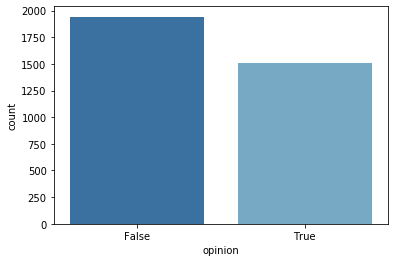

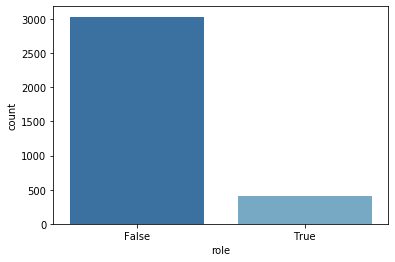

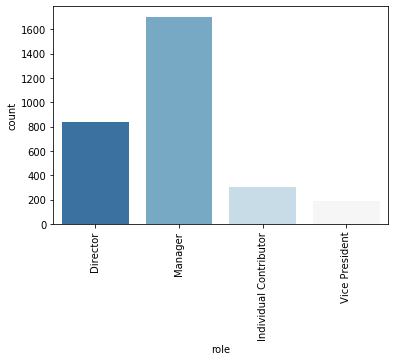

In [10]:
sns.countplot(data.opinion.isna())
plt.show()
sns.countplot(data.role.isna())
plt.show()
sns.countplot(data.role)
plt.xticks(rotation=90)
plt.show()

### Data preprocessing

In [11]:
data = data.dropna()

In [12]:
#module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = hub.Module(module_url)
embeddings = embed(data.opinion.values)

In [13]:
with tf1.Session() as session:
    session.run([tf1.global_variables_initializer(), tf1.tables_initializer()])
    text_vector = session.run(embeddings)

In [14]:
text_vector.shape

(1925, 512)

In [15]:
data.opinion.head()

3                                         Response time
9             timelines, and some specific deliverables
10    It seems sometimes the focus is on metrics and...
14    Integrated objectives.   Coat model to get wor...
18    Having integrated high quality solutions befor...
Name: opinion, dtype: object

In [16]:
with tf1.Session() as session:
    session.run([tf1.global_variables_initializer(), tf1.tables_initializer()])
    d = text_vector[0]-session.run(embed(data.opinion[0:1].values))[0]
    d = np.round(d,6)
    print(np.sum(d))

0.0


In [17]:
def get_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #kmeans = KMeans(n_clusters=center)
    
    kmeans = Pipeline([
        ("cluster",KMeans(n_clusters=center))
    ])
    
    model = kmeans.fit(data)
    labels = model.named_steps.get("cluster").labels_
    
    score = silhouette_score(data, labels, metric='euclidean')*100
    return score

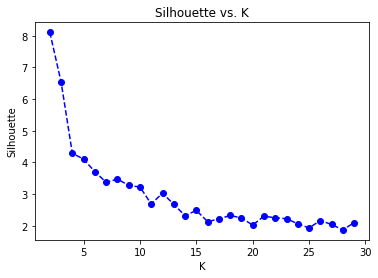

In [20]:
scores = []
centers = np.arange(2,30,1)
for center in centers:
    scores.append(get_score(text_vector, center))
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette');
plt.title('Silhouette vs. K');

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [83]:
kmeans = Pipeline([
    ("cluster",KMeans(n_clusters=3,random_state=4614))
])

In [84]:
kmeans.fit_transform(text_vector)

array([[0.7633098 , 1.040682  , 0.92036235],
       [0.8457343 , 0.8321623 , 0.8915592 ],
       [0.8622029 , 0.6246025 , 0.7297437 ],
       ...,
       [0.9502314 , 0.6382876 , 0.6294346 ],
       [0.9149499 , 0.8586111 , 0.87629026],
       [0.97398776, 0.9567779 , 0.77097505]], dtype=float32)

In [85]:
cluster = kmeans.predict(text_vector)

In [86]:
results = data.copy()

In [87]:
results["group"] = cluster

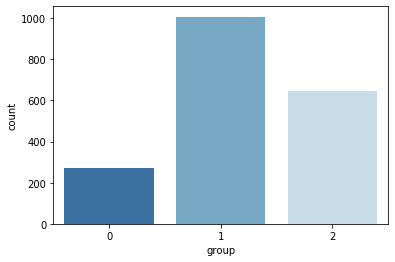

In [88]:
sns.countplot(results.group)

In [95]:
results[results.group==0]["opinion"].sample(20)

1691    Multiple supports worldwide for my problem no ...
1154          Timely response in solving technical issues
3023                   # of employees in the support team
1037                                            kindness 
190                                                     .
547     Communicate where to find things that the fiel...
2329                         Better  and faster services 
855                                      See priorities. 
2275        Development of new patient-centered solutions
2905    iT resuelve pero no es cercano en la adopción ...
1104                                                    -
1520    Maybe get better at resolving complex IT issues\n
96                         Availability, smiling people, 
853                         Collaberation cross functions
3145                       Response time could be shortly
2286                            Visibility to their work 
2339       Continue doing what you are doing.  Great Job!
2691    The fo

In [96]:
results[results.group==0]["opinion"].sample(20)

1465                                     System stability
1308                                            e trading
374                                   No tickets to India
1584            hold courses to better understand how IT 
526     Stop using so many abbreviations. It takes lon...
1544                   You do a nice job most of the time
1037                                            kindness 
367     It can be difficult to find information on the...
782     Pockets of stubbornness & resistance, tech for...
2696                                 A service strategy. 
1994                                          the systems
425     You need to employ more IT staff. Not enough s...
2084             Prioritization, they try to do too much.
2335                                             not sure
205                                                     ?
1204    Direction and alignment need improvement reall...
2421                                          proact more
2449          

In [97]:
results[results.group==1]["opinion"].sample(20)

2814    BAs do not take the time to read business requ...
2932    Responsiveness & knowledge of local contacts; ...
416     Too many inefficient and convoluted IT systems...
1464    Better understand Business need and customers ...
1470    To expand the capabilities for in-house sales ...
1764    Proactive solution proposals\nBeing closer to ...
733     We do too many tasks manually.  Most important...
865     Systems that enable better field engagement an...
1316    New technology that improves everyday work for...
2939    It is very challenging to set up new businesse...
85      It is confusing trying to find information fro...
642     It is a struggle to get a project done.  It se...
3163             flexibility in support of business needs
1697    Clarity on the ownership of Finance Systems......
393     Refine roles and responsibilities between IT a...
585     Consistency and reliability of services.  We u...
1325           Strategic alignment on Smart Factory tools
1297    Clarif

In [98]:
results[results.group==1]["opinion"].sample(20)

248     The budgeting process for acquisition and enha...
113     Increase volume of automation projects to brin...
1273    More clarity on how to engage with them on ven...
393     Refine roles and responsibilities between IT a...
1873          Stability of system\nCompability of systems
2110    Becoming more strategic in terms of bringing t...
1167    The IT environment should be much faster in ke...
1667    IT could improve process and cost. Typically 1...
3098    The quality, feature sets, ease of use, integr...
2108    Be customer centric.  Currently i see MDT IT a...
949     A unified infrastructure of legacy systems whi...
1440    Need to make process more simpler and automate...
3003    IT needs to develop a broader roadmap how to h...
848     Fix Single sign on (we call it several sign on...
1009    Standardize. simplify and combine operation sy...
175     IT should be focused on delivering exceptional...
2155    Improve Distributor Management System to incre...
2967    The ex

In [99]:
results[results.group==2]["opinion"].sample(20)

2432    Stability of the system (I am still on widows ...
208                enable seamless data transfer, access 
1976    It is difficult as a user with multiple issues...
2395    The overall systems are difficult work with an...
1245    at MMO:  the site has grown and with 700 emplo...
1210    Move all storage cloud systems (e.g. Box.com) ...
1858    The quality of the latest generation of laptop...
2380    The speed of mail server and internet is too s...
874     Integrate legacy Covidien!  After 4 years we s...
2054    please solve the problems: Outlook, Microsoft ...
2436       Response times to emails, non-urgent requests.
3156    Ensure acceptable  office environment for all ...
872     Need a much better process for SAP access, ver...
244            Speed of systems.  MAP agile is VERY slow.
1249    The local Wifi networks in North Haven as well...
940     sytems are very, very slow after move to cloud...
518     I've been on board for 6 months and my experie...
1150    Multip

In [100]:
results[results.group==2]["opinion"].sample(20)

1300    Microsoft 360 could be much more stable.  Redu...
2169    Response time, poor communication, better equi...
2209    insure that issues are resolved before they cl...
1591    Our conferencing technology.  It is impossible...
2457    Retention on Service desk personnel. Frequent ...
211     There seems to be too many issues with my PC, ...
2591    You're always able to fix my problems, but the...
74      Stop pushing updates and not letting us know a...
2427    To speed up for update hardware substitution s...
1811    SIMPLIFY !\nAllow local IT support to fix issu...
1275    Proactive engagement regarding advancements, u...
2058    It appears that IT holds other departments hos...
1860    Everything I listed in prior question on prior...
1230    Standardizing IT Platforms across the enterpri...
2971    '- ticket to get J drive access took 3 months ...
2001    The end of the year black out period is crippl...
798     The log in process to the IT portal.  I have t...
568          P

# First Conclusion
it seems like theare are 3 main topics in the comments 

> TOPIC 1 (Cluster 0) Response Time and Agility in solving problems - in which can be found good and bad comments. 

> TOPIC 2 (Cluster 1) Support and Relationship with other Departments - in which it seems more bad comments that good ones

> TOPIC 3 (Cluster 2) Hardware and Software - Laptops upgrades

In [101]:
pca = PCA(n_components=2)

In [102]:
pca_2dim = pca.fit_transform(text_vector)

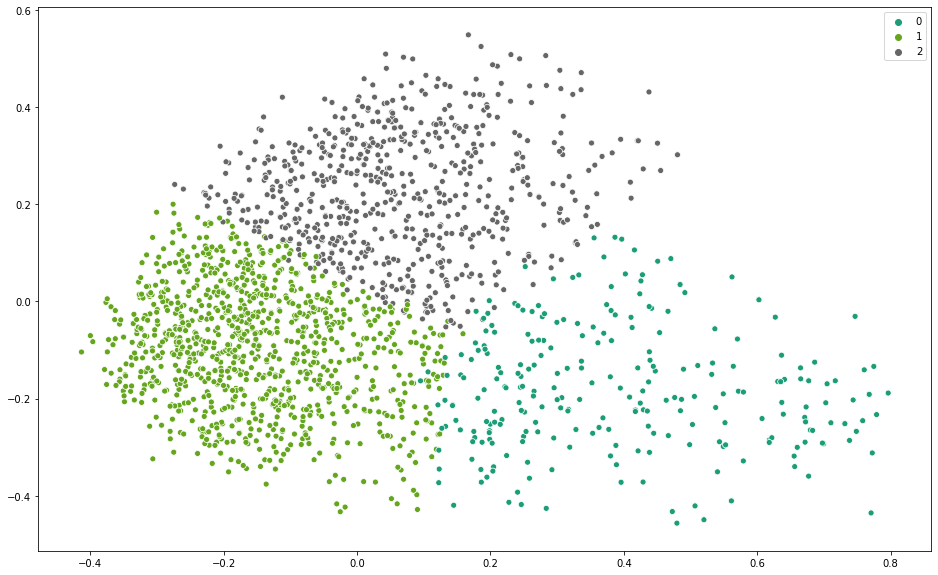

In [103]:
plt.figure(figsize=(16, 10))
sns.scatterplot(pca_2dim[:,0],pca_2dim[:,1],hue=cluster,palette="Dark2")
plt.show()

In [104]:
import nltk

In [135]:
import nltk
allWords = nltk.tokenize.word_tokenize(' '.join(results[results.group==0]["opinion"].values))
allWordDist = nltk.FreqDist(w.lower() for w in allWords)
stopwords = nltk.corpus.stopwords.words('english')
cluster0_allwords = nltk.FreqDist(w.lower() for w in allWords if w.lower() not in stopwords + [".",",",")","(","-"])

In [136]:
import nltk
allWords = nltk.tokenize.word_tokenize(' '.join(results[results.group==1]["opinion"].values))
allWordDist = nltk.FreqDist(w.lower() for w in allWords)
stopwords = nltk.corpus.stopwords.words('english')
cluster1_allwords = nltk.FreqDist(w.lower() for w in allWords if w.lower() not in stopwords + [".",",",")","(","-"])

In [137]:
import nltk
allWords = nltk.tokenize.word_tokenize(' '.join(results[results.group==2]["opinion"].values))
allWordDist = nltk.FreqDist(w.lower() for w in allWords)
stopwords = nltk.corpus.stopwords.words('english')
cluster2_allwords = nltk.FreqDist(w.lower() for w in allWords if w.lower() not in stopwords + [".",",",")","(","-"])

In [144]:
cluster0_allwords.most_common(20)

[('time', 22),
 ('response', 19),
 ('!', 19),
 ('support', 15),
 ('systems', 14),
 ('resources', 12),
 ('better', 12),
 ('need', 11),
 ('system', 11),
 ('business', 10),
 ('solutions', 9),
 ('think', 9),
 ('``', 8),
 ("''", 8),
 ('needs', 8),
 ('issues', 8),
 ('service', 8),
 ('understand', 7),
 ("n't", 7),
 ('many', 7)]

In [143]:
cluster1_allwords.most_common(20)

[('business', 431),
 ('systems', 387),
 ('work', 203),
 ('need', 197),
 ('system', 167),
 ('tools', 164),
 ('support', 163),
 ('solutions', 160),
 ("n't", 154),
 ('data', 151),
 ('new', 150),
 ('needs', 148),
 ('process', 144),
 ('get', 133),
 ('projects', 130),
 ('better', 129),
 ('project', 129),
 ('use', 122),
 ('time', 122),
 ('processes', 120)]

In [142]:
cluster2_allwords.most_common(20)

[('systems', 147),
 ("n't", 138),
 ('time', 130),
 ('work', 127),
 ('issues', 124),
 ('get', 117),
 ('system', 106),
 ('support', 106),
 ('help', 101),
 ('need', 101),
 ('access', 93),
 ('new', 89),
 ('times', 84),
 ('issue', 78),
 ('one', 78),
 ('many', 78),
 ("'s", 78),
 ('computer', 75),
 ('use', 74),
 ('would', 73)]